In [2]:
import os
os.getcwd()


'/home/ankanguha/Desktop/Training/WEEK 6/ml-project/notebooks'

In [3]:
# Step 1: Add src folder to sys.path
import sys
import os

# Absolute path to src
src_path = "/home/ankanguha/Desktop/Training/WEEK 6/ml-project/src"
sys.path.append(src_path)
PROCESSED_PATH = "data/processed/bmw_final.csv"
# Step 2: Import functions from your pipeline
from pipelines.data_pipeline import load_data, clean_data, save_data
# Step 3: Test the functions
RAW_PATH = "../data/raw/bmw.csv"  # relative to notebooks folder

# Load and clean the data
df = load_data(RAW_PATH)
df_clean = clean_data(df)
save_data(df_clean, PROCESSED_PATH)
# Show top rows
df_clean.head()


2026-01-27 18:02:45,696 | INFO | Loading raw data from ../data/raw/bmw.csv
2026-01-27 18:02:45,705 | INFO | Data loaded with shape: (10781, 9)
2026-01-27 18:02:45,705 | INFO | Starting cleaning process...
2026-01-27 18:02:45,713 | INFO | Dropped 117 duplicate rows
/home/ankanguha/Desktop/Training/WEEK 6/ml-project/src/pipelines/data_pipeline.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/home/ankanguha/Desktop/Training/WEEK 6/ml-project/src/pipelines/data_pipeline.py:37: SettingW

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200.0,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000.0,Automatic,14827,Petrol,145,42.8,2.0
5,5 Series,2016,14900.0,Automatic,35309,Diesel,125,60.1,2.0
6,5 Series,2017,16000.0,Automatic,38538,Diesel,125,60.1,2.0
10,X3,2017,15500.0,Manual,74907,Diesel,145,52.3,2.0


In [4]:
processed_path = "../data/processed/bmw_final.csv"
df_clean.to_csv(processed_path, index=False)
print(f"Cleaned dataset saved to {processed_path}")


Cleaned dataset saved to ../data/processed/bmw_final.csv


In [5]:
import sys
from pathlib import Path

import pandas as pd
# project root (ml-project)
PROJECT_ROOT = Path.cwd().parent

# add src to path
sys.path.append(str(PROJECT_ROOT / "src"))


In [6]:
from features.build_features import build_features
from sklearn.model_selection import train_test_split
X, y = build_features(df_clean)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [7]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(3780, 18) (946, 18)
(3780,) (946,)


In [8]:
import numpy as np
import pandas as pd
from features.feature_selector import remove_highly_correlated_features
X_train_df = pd.DataFrame(X_train)

# Select numeric columns only
X_train_num = X_train_df.select_dtypes(include=np.number)

X_train_corr, X_dropped=remove_highly_correlated_features(X_train_num, 0.85)
X_test_corr = X_test[X_train_corr.columns]

print(X_train_corr.shape)

Dropped due to correlation > 0.85: ['car_age', 'mileage_per_year', 'log_tax', 'mpg_per_engine', 'tax_per_engine']
(3780, 8)


In [9]:

from features.feature_selector import select_features_mutual_info

selected_features, mi_df = select_features_mutual_info(X_train_corr, y_train)
mi_df

,feature,mi_score
0,year,0.687236
1,mileage,0.605364
5,log_mileage,0.592549
3,mpg,0.434492
2,tax,0.221575
6,is_automatic,0.055163
7,is_diesel,0.031935
4,engineSize,0.000937


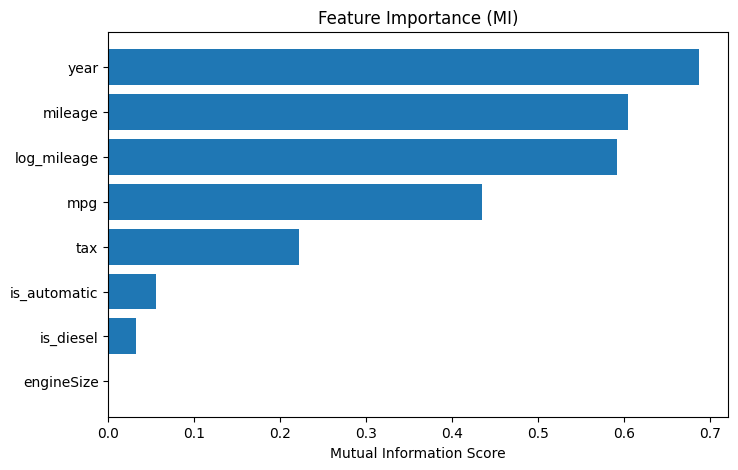

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(mi_df["feature"], mi_df["mi_score"])
plt.xlabel("Mutual Information Score")
plt.title("Feature Importance (MI)")
plt.gca().invert_yaxis()
plt.show()


In [11]:
X_train_mi = X_train_corr[selected_features]
X_test_mi = X_test_corr[selected_features]

print(X_train_mi.shape, X_test_mi.shape)

(3780, 7) (946, 7)


In [12]:
from features.feature_selector import select_features_rfe

selected_rfe_features = select_features_rfe(X_train_mi, y_train)
print(selected_rfe_features)


Index(['year', 'log_mileage', 'mpg', 'is_automatic', 'is_diesel'], dtype='object')


In [13]:
X_train_final = X_train_mi[selected_rfe_features]
X_test_final = X_test_mi[selected_rfe_features]

X_train_final.shape, X_test_final.shape
X_train_final

,year,log_mileage,mpg,is_automatic,is_diesel
2850,2017,10.684623,60.1,0,1
6145,2019,8.547916,52.3,0,1
3314,2020,4.663439,51.4,0,1
604,2017,9.957313,48.7,0,0
2000,2018,9.873492,65.7,0,1
...,...,...,...,...,...
9870,2014,10.203629,55.4,0,1
1038,2013,11.012248,60.1,0,1
6105,2020,1.791759,37.2,0,0
7595,2016,10.819798,54.3,1,1


In [19]:
from training.train import train_all_models

models, best_model, metrics = train_all_models(
    X_train_final, X_test_final, y_train, y_test
)


Best model: XGBoost with R2=0.8034
All models and metrics saved.


/home/ankanguha/Desktop/Training/WEEK 6/ml-project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
